# Load custom classes, functions and more
First cell is some custom functions and classes for plotting and saving model performance

In [49]:
import os
import psutil
process = psutil.Process(os.getpid())

def print_used_GB():
        print("Used RAM(GB):", process.memory_info().rss / 1e9, sep=" ")  # in gigabytes

svmem(total=17179869184, available=9938690048, percent=42.1, used=5729566720, free=6872518656, active=3074891776, inactive=3051266048, wired=2654674944)


In [25]:
from keras.callbacks import Callback
import json

# What value maps to what class
mapping = {
    0: "Null class",
    1: "Necrotic and non-enhancing tumor core",
    2: "Edema",
    4: "GD-enhancing tumor"
}

# fixme: skulle gå att göra bättre igenom att skicka med en tex tuple med titlarna
# och returnera ett matplotlib-objekt istället för då hade man inte behövt ha olika
# funktioner för "plot_modalities" och "plt_OHE" och också kunna ha två stycken figurer med 
# 2*2 subplots i en cell.
def plot_modalities(x):
    # Make sure input data is of correct shape
    assert x.shape == (240, 240, 4), 'Shape of input data is incorrect'
    plt.subplot('221')
    plt.imshow(x[:,:,0])
    plt.axis('off')
    plt.title('T1')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(x[:,:,1])
    plt.axis('off')
    plt.title('T1ce')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(x[:,:,2])
    plt.axis('off')
    plt.title('T2')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(x[:,:,3])
    plt.axis('off')
    plt.title('FLAIR')
    plt.colorbar()

def plot_OHE(y):
    # Make sure input data is of correct shape
    assert y.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(y[:,:,0])
    plt.axis('off')
    plt.title('Null')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(y[:,:,1])
    plt.axis('off')
    plt.title('"Necrotic and non-enhancing tumor core"')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(y[:,:,2])
    plt.axis('off')
    plt.title('Edema')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(y[:,:,3])
    plt.axis('off')
    plt.title('GD-enhancing tumor')
    plt.colorbar()

def shift_and_scale(x):
    assert len(x.shape) == 2, 'The input must be 2 dimensional'
    result = x - np.mean(x)
    result /= np.std(x)
    return result

def OHE(Y, mapping):
    '''
    Takes in a picture as a matrix with labels and returns a one hot encoded tensor
    
    Parameters:
    Y is the picture
    Mapping is what value corresponds to what label
    
    Returns:
    A tensor with a channel for each label.
    '''
    shape = Y.shape
    labels = mapping.keys()
    one_hot_enc = np.zeros(list(shape) + [len(labels)])
    
    for i, label in enumerate(labels):
        temp = np.zeros(shape)
        ind = Y == label
        temp[ind] = 1
        one_hot_enc[:, :, i] = temp
    return one_hot_enc

#fixme: I don't know if providing this mapping is necessary
# probably could be provided inside function instead.
def OHE_uncoding(y, mapping):
    result = np.argmax(y, axis=2)
    labels = mapping.keys()
    temp = np.zeros(result.shape)
    for i, label in enumerate(labels):
        ind = result == i
        temp[ind] = label
    return temp

'''
def intersection_over_union(y_true, y_pred):
    y_true = K.eval(y_true)
    y_pred = K.eval(y_pred)
    
    values = np.array([0., 1.])
    unique_y_pred = np.unique(y_pred)
    unique_y_true = np.unique(y_true)
    assert np.array_equal(y_pred.shape, y_true.shape), 'Prediction and ground truth must have same shape'
    assert np.array_equal(values, unique_y_pred), 'yhat and y must be one hot encodings'
    assert np.array_equal(values, unique_y_true), 'yhat and y must be one hot encodings'
    
    # The slicing in the last index is because the null class bloats
    # the intersection over union because there are so many pixels which
    # have the value zero
    y_pred[:,:,0] = y_pred[:,:,0] == False
    y_true[:,:,0] = y_true[:,:,0] == False
    
    # Intersection is where there is 2 True values
    intersection = (y_pred + y_true) == 2
    # Union is where it is not zero
    union = (y_pred + y_true) > 0
    
    size_int = np.count_nonzero(intersection)
    size_uni = np.count_nonzero(union)
    
    return K.variable(value=size_int/size_uni)
'''

from keras import backend as K
# IoU for all classes in tumor
def IoU_T(y_true, y_pred):
    values = np.array([0., 1.])
    unique_y_pred = np.unique(y_pred)
    unique_y_true = np.unique(y_true)
    assert np.array_equal(y_pred.shape, y_true.shape), 'Prediction and ground truth must have same shape'
    assert np.array_equal(values, unique_y_pred), 'yhat and y must be one hot encodings'
    assert np.array_equal(values, unique_y_true), 'yhat and y must be one hot encodings'
    
    # The slicing in the last index is because the null class bloats
    # the intersection over union because there are so many pixels which
    # have the value zero
    y_pred[:,:,0] = y_pred[:,:,0] == False
    y_true[:,:,0] = y_true[:,:,0] == False
    
    # Intersection is where there is 2 True values
    intersection = (y_pred[:,:,0] + y_true[:,:,0]) == 2
    # Union is where it is not zero
    union = (y_pred[:,:,0] + y_true[:,:,0]) > 0
    
    size_int = np.count_nonzero(intersection)
    size_uni = np.count_nonzero(union)
    
    return size_int/size_uni

'''
# Load config file to session here
import json
config_path = "Training_session_1/config.json"
with open(config_path, 'r') as config_file:
    config = json.load(config_file)
'''

def reset_config(config, config_path=None, weights_path=None):
    new_config = config
    if weights_path:
        assert type(weights_path) == str, 'The weight path must be a string'
        new_config['weights_path'] = weights_path
    if config_path:
        assert type(config_path) == str, 'The config path must be a string'
        new_config['config_path'] = config_path
    new_config['history']['training_samples_used'] = 0
    new_config['history']['loss'] = []
    new_config['history']['val_loss'] = []
    new_config['history']['IoU_T'] = []
    new_config['keep_training'] = False
    
    with open(new_config['config_path'],'w') as f:
        f.write(json.dumps(new_config))
    
class CallbackJSON(Callback):
    """ CallbackJSON descends from Callback
        and is used to write the number of training samples that the model has been trained on
        and the loss for a epoch
    """
        
    def __init__(self, config):
        """Save params in constructor
        config: Is a dictionary loaded from a JSON file which is used to keep track of training
        """
        self.config = config
        self.config_path = config['config_path']
        self.config['history']['IoU_T'] = []

    def on_epoch_end(self, epoch, logs):
        """
        Updates the history of the config dict and saves it to a file
        """
        # How many effective training samples have been used
        self.config['history']['training_samples_used'] += self.config['samples_used']
        # Logs the loss of the current epoch
        self.config['history']['loss'].append(logs['loss'])
        '''
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        yhat = np.asarray(self.model.predict(X_val))
        yhat = OHE_uncoding(yhat, mapping)
        yhat = OHE(yhat, mapping)
        #print('yhat shape:', yhat.shape, sep=" ")
        #print('yhat unique:', np.unique(yhat), sep=" ")
        self.config['history']['IoU_T'].append(IoU_T(y_val, yhat))
        '''
        print_used_GB()
        
        #fixme: add the same code but for "val_loss"
        # Save new config file
        with open(self.config_path, "w") as f:
            f.write(json.dumps(self.config))

print('Finished')
print_used_GB()

Finished
Used RAM(GB): 2.617860096


# Loading the corrected brats data

In [ ]:
import ants
import matplotlib.pyplot as plt
import numpy as np
import glob
from os import listdir

t1_path = "brats/0_t1_corrected.nii.gz"
img = ants.image_read(t1_path)
img = img.numpy()
shape = img.shape
num_patients = 5
modalities = 4

data = np.zeros((shape[2]*num_patients, shape[0], shape[1], modalities))
OHE_labels = np.zeros((shape[2]*num_patients, shape[0], shape[1], len(mapping)))

num_slices = shape[2]
for i in range(num_patients):
    print('Patient ' + str(i))
    t1_path = "brats/" + str(i) + "_t1_corrected.nii.gz"
    t1ce_path = "brats/" + str(i) + "_t1ce_corrected.nii.gz"
    t2_path = "brats/" + str(i) + "_t2_corrected.nii.gz"
    flair_path = "brats/" + str(i) + "_flair_corrected.nii.gz"
    gt_path = "brats/" + str(i) + "_seg.nii.gz"

    img_t1 = ants.image_read(t1_path)
    img_t1ce = ants.image_read(t1ce_path)
    img_t2 = ants.image_read(t2_path)
    img_flair = ants.image_read(flair_path)
    img_gt = ants.image_read(gt_path)

    img_t1 = img_t1.numpy()
    img_t1ce = img_t1ce.numpy()
    img_t2 = img_t2.numpy()
    img_flair = img_flair.numpy()
    img_gt = img_gt.numpy()
    
    # Trying to normalize data
    img_t1 = img_t1/np.max(img_t1)
    img_t1ce = img_t1ce/np.max(img_t1ce)
    img_t2 = img_t2/np.max(img_t2)
    img_flair = img_flair/np.max(img_flair)
    
    # The last axis will become the first axis
    data[(i*num_slices):((i+1)*num_slices), :, :, 0] = np.moveaxis(img_t1, -1, 0)
    data[(i*num_slices):((i+1)*num_slices), :, :, 1] = np.moveaxis(img_t1ce, -1, 0)
    data[(i*num_slices):((i+1)*num_slices), :, :, 2] = np.moveaxis(img_t2, -1, 0)
    data[(i*num_slices):((i+1)*num_slices), :, :, 3] = np.moveaxis(img_flair, -1, 0)
    
    for j in range(num_slices):
        OHE_labels[i*num_slices+j, :, :, :] = OHE(img_gt[:, :, j], mapping)

In [ ]:
# This will show a slice of the last patient
ind = 70
plot_modalities(data[ind])

In [ ]:
# Visualise one hot encoding
my_OHE = OHE(img_gt[:, :, ind], mapping)
test = 155 - 70
my_OHE = OHE_labels[-test, :, :, :]
plot_OHE(my_OHE)

# Read raw data HGG
Loads the first patient among the patients with HGG

In [9]:
import ants
import matplotlib.pyplot as plt
import numpy as np
import glob
from os import listdir

t1_path = "MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii.gz"
t1ce_path = "MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii.gz"
t2_path = "MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii.gz"
flair_path = "MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii.gz"
gt_path = "MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii.gz"

img_t1 = ants.image_read(t1_path)
img_t1ce = ants.image_read(t1ce_path)
img_t2 = ants.image_read(t2_path)
img_flair = ants.image_read(flair_path)
img_gt = ants.image_read(gt_path)

img_t1 = img_t1.numpy()
img_t1ce = img_t1ce.numpy()
img_t2 = img_t2.numpy()
img_flair = img_flair.numpy()
img_gt = img_gt.numpy()

# I have here chosen to do shift and scale per image, which is not the only way to do it.
for i in range(img_t1.shape[2]):
    # shift and scale data
    img_t1[:, :, i] = shift_and_scale(img_t1[:, :, i])
    img_t1ce[:, :, i] = shift_and_scale(img_t1ce[:, :, i])
    img_t2[:, :, i] = shift_and_scale(img_t2[:, :, i])
    img_flair[:, :, i] = shift_and_scale(img_flair[:, :, i])
    
uncorrected_data = np.zeros((155, 240, 240, 4))

# The last axis will become the first axis
uncorrected_data[:, :, :, 0] = np.moveaxis(img_t1, -1, 0)
uncorrected_data[:, :, :, 1] = np.moveaxis(img_t1ce, -1, 0)
uncorrected_data[:, :, :, 2] = np.moveaxis(img_t2, -1, 0)
uncorrected_data[:, :, :, 3] = np.moveaxis(img_flair, -1, 0)

num_slices = 155
uncorrected_OHE_labels = np.zeros((num_slices, 240, 240, 4))

for j in range(num_slices):
    uncorrected_OHE_labels[j, :, :, :] = OHE(img_gt[:, :, j], mapping)
print('Finished')
print_used_GB()

/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


Finished
Used RAM(GB): 1.461891072


# Read raw data LGG

In [ ]:
import ants
import matplotlib.pyplot as plt
import numpy as np
import glob
from os import listdir

t1_path = "MICCAI_BraTS_2019_Data_Training/LGG/BraTS19_2013_0_1/BraTS19_2013_0_1_t1.nii.gz"
t1ce_path = "MICCAI_BraTS_2019_Data_Training/LGG/BraTS19_2013_0_1/BraTS19_2013_0_1_t1ce.nii.gz"
t2_path = "MICCAI_BraTS_2019_Data_Training/LGG/BraTS19_2013_0_1/BraTS19_2013_0_1_t2.nii.gz"
flair_path = "MICCAI_BraTS_2019_Data_Training/LGG/BraTS19_2013_0_1/BraTS19_2013_0_1_flair.nii.gz"
gt_path = "MICCAI_BraTS_2019_Data_Training/LGG/BraTS19_2013_0_1/BraTS19_2013_0_1_seg.nii.gz"

img_t1 = ants.image_read(t1_path)
img_t1ce = ants.image_read(t1ce_path)
img_t2 = ants.image_read(t2_path)
img_flair = ants.image_read(flair_path)
img_gt = ants.image_read(gt_path)

img_t1 = img_t1.numpy()
img_t1ce = img_t1ce.numpy()
img_t2 = img_t2.numpy()
img_flair = img_flair.numpy()
img_gt = img_gt.numpy()

# I have here chosen to do shift and scale per image, which is not the only way to do it.
for i in range(img_t1.shape[2]):
    # shift and scale data
    img_t1[:, :, i] = shift_and_scale(img_t1[:, :, i])
    img_t1ce[:, :, i] = shift_and_scale(img_t1ce[:, :, i])
    img_t2[:, :, i] = shift_and_scale(img_t2[:, :, i])
    img_flair[:, :, i] = shift_and_scale(img_flair[:, :, i])
    
uncorrected_data = np.zeros((155, 240, 240, 4))

# The last axis will become the first axis
uncorrected_data[:, :, :, 0] = np.moveaxis(img_t1, -1, 0)
uncorrected_data[:, :, :, 1] = np.moveaxis(img_t1ce, -1, 0)
uncorrected_data[:, :, :, 2] = np.moveaxis(img_t2, -1, 0)
uncorrected_data[:, :, :, 3] = np.moveaxis(img_flair, -1, 0)

uncorrected_OHE_labels = np.zeros((155, 240, 240, 4))

print(np.unique(img_gt))

num_slices = 155
for j in range(num_slices):
    uncorrected_OHE_labels[j, :, :, :] = OHE(img_gt[:, :, j], mapping)

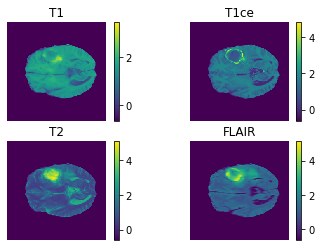

In [3]:
x = uncorrected_data[70,:,:,:]
plot_modalities(x)

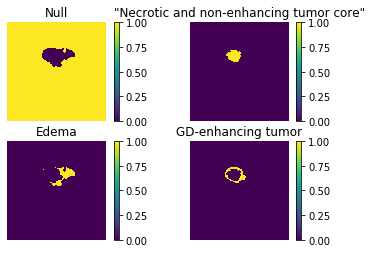

In [4]:
plot_OHE(uncorrected_OHE_labels[70, :, :, :])

# UNet definition

In [14]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import metrics
from keras import backend as keras

def unet(pretrained_weights = None, input_size = (256, 256, 1), num_classes=1):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4, up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
  merge7 = concatenate([conv3, up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
  merge8 = concatenate([conv2, up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
  merge9 = concatenate([conv1, up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(num_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  
  # Not sure what the three lines below are doing
  reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
  permute = Permute((2, 1))(reshape)
  activation = Softmax(axis=-1)(permute)
  
  model = Model(input = inputs, output = activation)
  model.compile(
      optimizer = Adam(lr=0.0001), 
      loss = 'categorical_crossentropy', 
      metrics = ['accuracy']
  )
    
  if (pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

In [16]:
print_used_GB()
my_unet = unet()
print_used_GB()

W1004 14:43:56.872013 4661622208 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 14:43:56.904989 4661622208 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 14:43:56.935176 4661622208 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1004 14:43:56.988606 4661622208 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_p

Used RAM(GB): 1.474838528


W1004 14:43:57.080463 4661622208 deprecation.py:506] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1004 14:43:57.160099 4661622208 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2239: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
W1004 14:43:57.345816 4661622208 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-pack

Used RAM(GB): 1.483395072


# With custom callback
Overfit model on 1 data point of uncorrected data

In [47]:
import json
# Set current training session
config_path = "testing_metric/config.json"
with open(config_path, 'r') as f:
    config = json.loads(f.read())
reset_config(config)
print(config)
del my_unet
del x
del y
print_used_GB()


{'weights_path': 'testing_metric/session_0_weights.h5', 'config_path': 'testing_metric/config.json', 'samples_used': 1, 'keep_training': False, 'history': {'training_samples_used': 0, 'loss': [], 'val_loss': [], 'IoU_T': []}, 'IoU': []}
Used RAM(GB): 1.856028672


In [48]:
# The path to where to save weights and initialize ModelCheckpoint
weights_path = config['weights_path']
from keras.callbacks import ModelCheckpoint
MyModelCheckPoint = ModelCheckpoint(weights_path, verbose=0, save_weights_only=True)

if config['keep_training'] == True:
    # Keep training on the old weights
    my_unet.load_weights(weights_path)
else:
    # Initialize network
    my_unet = unet(
        input_size = (240, 240, 4), 
        num_classes = 4
    )
    config['keep_training'] = True
    
#i = 70 has all labels present in the image
n = uncorrected_data.shape[0]
#i = np.random.randint(n, size=[samples_used,])
i = np.arange(0, 155)
x = uncorrected_data[i, :, :, :]
y = uncorrected_OHE_labels[i, :, :, :]

x_val = uncorrected_data[i, :, :, :]
y_val = uncorrected_OHE_labels[i, :, :, :]

x = x.reshape(len(i), 240, 240, 4)
x_val = x.reshape(len(i), 240, 240, 4)
# You have to reshape the output in this hacky way for keras to be able to use softmax in last layer
y = y.reshape(len(i), -1, 4)
y_val = y.reshape(len(i), -1, 4)

# Returns an object with accuracy and loss
history = my_unet.fit(x=x, 
                      y=y, 
                      batch_size=None,
                      epochs=10, 
                      verbose=1, 
                      callbacks=[CallbackJSON(config=config), MyModelCheckPoint],
                      validation_split=0.0, 
                      #validation_data=(x_val, y_val),
                      shuffle=True, 
                      class_weight=None, 
                      sample_weight=None, 
                      initial_epoch=0, 
                      steps_per_epoch=None, 
                      validation_steps=None, 
                      validation_freq=1)


/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


Epoch 1/10
155/155 [==============================] - 541s 3s/step - loss: nan - acc: 0.8840
Used RAM(GB): 1.463697408
Epoch 2/10
155/155 [==============================] - 509s 3s/step - loss: nan - acc: 0.9875
Used RAM(GB): 1.669402624
Epoch 3/10
 32/155 [=====>........................] - ETA: 6:34 - loss: nan - acc: 0.9859

KeyboardInterrupt: 

In [46]:
# %whos
import sys
sys.getsizeof(my_unet.weights)
print(my_unet.weights)

[<tf.Variable 'conv2d_185/kernel:0' shape=(3, 3, 4, 64) dtype=float32_ref>, <tf.Variable 'conv2d_185/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2d_186/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'conv2d_186/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2d_187/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'conv2d_187/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'conv2d_188/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>, <tf.Variable 'conv2d_188/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'conv2d_189/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'conv2d_189/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'conv2d_190/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'conv2d_190/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'conv2d_191/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>, <tf.Variable 'conv2d_191/bias:0' shape=(512,) dtype=float32_ref>,

/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


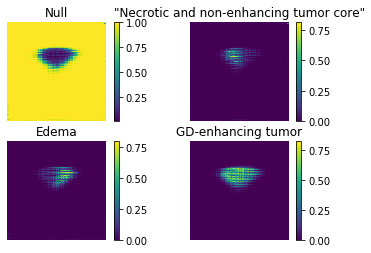

In [100]:
# Make a prediction on the sample we overfitted on
j = 70

my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
my_unet.load_weights(config['weights_path'])

yhat = my_unet.predict(x = uncorrected_data[j, :, : ,:].reshape(1, 240, 240, 4))
y = uncorrected_OHE_labels[j, :, : ,:]
plot_OHE(yhat.reshape(240, 240, 4))

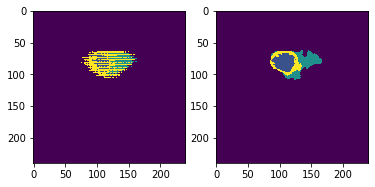

In [103]:
# Compare prediction with ground truth
yhat1 = yhat.reshape(240, 240, 4)
y1 = y.reshape(240, 240, 4)

plt.subplot('121')
#plt.imshow(uncorrected_data[j, :, :, 0])
#plt.imshow(OHE_uncoding(yhat1, mapping),alpha=.5)
plt.imshow(OHE_uncoding(yhat1, mapping))
plt.subplot('122')
#plt.imshow(uncorrected_data[j, :, :, 0])
#plt.imshow(OHE_uncoding(y1, mapping),alpha=.5)
plt.imshow(OHE_uncoding(y1, mapping))

[0.40612352630652826, 0.0008115126595974897, 0.4462474645030426, 0.039561129620261995, 0.25302663438256656, 0.0005220991988477811, 0.041107382550335574, 0.0012271931565934562, 0.1886945912972753, 0.008873161797393175, 0.30058479532163745, 0.0012042562369688691, 0.1517040731504572, 0.0025908124430467955, 0.3751962323390895, 0.0076073880121718205, 0.4143028365960847, 0.0013928820157502813, 0.39295831647106433, 0.004074648980455797, 0.6044340723453909, 0.003933813152695456, 0.3361788617886179, 0.005110823232950613, 0.5337023770758711, 0.011553273427471117, 0.4815390594636611, 0.001657045114389566, 0.3292181069958848, 0.0031464328643145017, 0.6217725052337753, 0.0059967642093415865, 0.46012024048096195, 0.0009443543645207847, 0.5866505830317652, 0.003328460983040699, 0.5560016057808109, 0.0012974779162149193, 0.42283822920976416, 0.0037314746365332487, 0.6799420709630702, 0.004657457204119653, 0.3920686835650041, 0.0008058306323084362, 0.38810900082576383, 0.0027558429169537335, 0.64114490

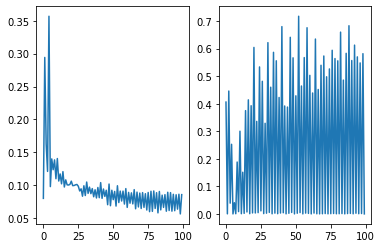

In [74]:
# Plot loss
plt.subplot('121')
plt.plot(config['history']['loss'])
plt.subplot('122')
plt.plot(config['history']['IoU_T'])

In [ ]:
# Test on 100 samples which the network was not trained on
test_data = data[samples_used:(samples_used+100), :, :, :]
test_labels = OHE_labels[samples_used:(samples_used+100), :, :, :]
test_labels = test_labels.reshape(100, -1, 4)
print(my_unet.evaluate(x = test_data, y=test_labels))


In [ ]:
# Save a smaller dataset for drive as well
data_small = data[100:120, :, :, :]
np.save('numpy_data_small', data_small)
labels_small = OHE_labels[100:120, :, :, :]
np.save('numpy_labels_small',  labels_small)

In [ ]:
# Save data and labels to upload to drive
np.save('numpy_data', data)
np.save('numpy_labels', OHE_labels)

In [ ]:
my_unet.save_weights('Training_session_1/my_unet_corrected_data.h5')

In [ ]:
names = ('t1', 't2', 't1ce', 'flair')

ground_truth = OHE_uncoding(uncorrected_OHE_labels[70, :, :, :], mapping)

for i, name in enumerate(names):
    plt.imshow(uncorrected_data[70,:,:,i])
    plt.axis('off')
    plt.savefig('figures/brain_example/'+name+'_example.png', transparent=True)

plt.imshow(ground_truth)
plt.legend(names)
plt.axis('off')
plt.savefig('figures/brain_example/gt.png', transparent=True)